In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
#gpuの確認
print(torch.cuda.is_available())

True


In [2]:
import torchtext
from torchtext.data.utils import get_tokenizer

toke = get_tokenizer('spacy')
toke('I am N')

['I', 'am', 'N']

In [3]:
import string
import re

# 以下の記号はスペースに置き換えます（カンマ、ピリオドを除く）。
# punctuationとは日本語で句点という意味です
print("区切り文字：", string.punctuation)
# !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# 前処理


def preprocessing_text(text):
    # 改行コードを消去
    text = re.sub('<br />', '', text)

    # カンマ、ピリオド以外の記号をスペースに置換
    for p in string.punctuation:
        if (p == ".") or (p == ","):
            continue
        else:
            text = text.replace(p, " ")

    # ピリオドなどの前後にはスペースを入れておく
    text = text.replace(".", " . ")
    text = text.replace(",", " , ")
    return text

# 分かち書き（今回はデータが英語で、簡易的にスペースで区切る）


def tokenizer_punctuation(text):
    return text.strip().split()


# 前処理と分かち書きをまとめた関数を定義
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_punctuation(text)
    return ret


# 動作を確認します
print(tokenizer_with_preprocessing('I like cats+'))

区切り文字： !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['I', 'like', 'cats']


In [4]:
import torchtext
from torchtext.data.utils import get_tokenizer

#テキストに処理を行うFieldを定義
#fix_lengthはtokenの数
TEXT = torchtext.data.Field(sequential=True, use_vocab=True, tokenize=tokenizer_with_preprocessing,
                            lower=True, include_lengths=True, batch_first=True, fix_length=40)

LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

#pandasでcsvを保存するときに、labelをintでキャストしておかないとエラーでるから注意
train_ds, val_ds, test_ds = torchtext.data.TabularDataset.splits(
    path='drive/My Drive/dataset/CBET/ekman', train='train.csv', validation='val.csv', 
    test='test.csv', format='csv', fields=[('Text', TEXT), ('Label', LABEL)])

In [5]:
from torchtext.vocab import Vectors

english_fasttext_vectors = Vectors(name='drive/My Drive/wiki-news-300d-1M.vec')

print(english_fasttext_vectors.dim)
print(len(english_fasttext_vectors.itos))

100%|█████████▉| 999260/999994 [02:05<00:00, 8119.64it/s]

300
999994


In [38]:
#ボキャブラリを作成する
TEXT.build_vocab(train_ds, vectors=english_fasttext_vectors)

print(TEXT.vocab.stoi)

batch_size = 64
d_model = 300
hidden_size = 512
output_dim = 5
dropout_rate = 0.1

defaultdict(<function _default_unk_index at 0x7f42ed862488>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'to': 3, 'a': 4, 'i': 5, 'user': 6, 'of': 7, 'you': 8, 'and': 9, 'is': 10, 'in': 11, 'my': 12, 'for': 13, 'on': 14, 'it': 15, 'me': 16, 'that': 17, 'this': 18, 'with': 19, 'not': 20, 'be': 21, 'so': 22, 'your': 23, 'are': 24, 'have': 25, 'can': 26, 'at': 27, 's': 28, 'just': 29, 'life': 30, 'no': 31, 'what': 32, 'day': 33, 'like': 34, 'all': 35, 'people': 36, 'love': 37, 'when': 38, 'im': 39, 'its': 40, 'but': 41, 'dont': 42, 'do': 43, 'up': 44, 'out': 45, 'we': 46, 'from': 47, 'how': 48, 'get': 49, 'good': 50, 'was': 51, 'fear': 52, 'now': 53, 'one': 54, 'time': 55, 'about': 56, 'by': 57, 'they': 58, 'if': 59, 'will': 60, 'why': 61, 't': 62, 'insta': 63, 'as': 64, 'free': 65, 'new': 66, 'who': 67, 'an': 68, 'today': 69, 'or': 70, 'more': 71, 'night': 72, 'go': 73, 'smile': 74, 'happy': 75, 'live': 76, 'girl': 77, 'chat': 78, 'self': 79, 'our': 80, 'there': 81, 'know': 82, 'has': 83, 'u': 84

In [39]:
#データローダーを作成
train_dl = torchtext.data.Iterator(train_ds, batch_size=batch_size, train=True)
val_dl = torchtext.data.Iterator(val_ds, batch_size=batch_size, train=False, sort=False)
test_dl = torchtext.data.Iterator(test_ds, batch_size=batch_size, train=False, sort=False)

#テスト
batch = next(iter(val_dl))
print(len(batch.Text[0][0]))
print(batch.Label)

40
tensor([4, 0, 2, 0, 2, 4, 4, 3, 1, 4, 2, 2, 1, 2, 2, 2, 1, 2, 3, 3, 0, 3, 4, 1,
        1, 3, 0, 2, 4, 1, 2, 2, 2, 3, 1, 2, 4, 3, 3, 4, 0, 0, 1, 3, 0, 3, 4, 0,
        0, 1, 2, 2, 1, 1, 4, 3, 2, 3, 3, 3, 2, 4, 4, 2])


In [40]:
class Embedder(nn.Module):
  def __init__(self, text_embedding_vectors, dropout_rate):
    super(Embedder, self).__init__()
    #tokenの数と、分散表現の次元数
    self.embeddings = nn.Embedding.from_pretrained(
        embeddings=text_embedding_vectors, freeze=True)
    self.dropout = nn.Dropout(dropout_rate)
  
  def forward(self, x):
    x = self.embeddings(x)
    x = self.dropout(x)
    return x


class LSTM_Layer(nn.Module):
  def __init__(self, d_model, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(d_model, hidden_size, batch_first=True)

  #入力と(h, c)のタプル
  def forward(self, x):
    output, hidden = self.lstm(x)
    return output, hidden

  
class ClassificationHead(nn.Module):
  def __init__(self, hidden_size, output_dim):
    super().__init__()
    self.linear = nn.Linear(hidden_size, output_dim)
    nn.init.normal_(self.linear.weight, std=0.02)
    nn.init.normal_(self.linear.bias, 0)

  def forward(self, x):
    output = self.linear(x)
    return output

class LSTM_Classification(nn.Module):
  def __init__(self, text_embedding_vectors, d_model, hidden_size, output_dim, dropout_rate):
    super().__init__()
    self.hidden_size = hidden_size
    self.net1 = Embedder(text_embedding_vectors, dropout_rate)
    self.net2 = LSTM_Layer(d_model, hidden_size)
    self.net3 = ClassificationHead(hidden_size, output_dim)

  def forward(self, x):
    x1 = self.net1(x) # [batch_size, ntoken, d_model]
    x2, (ht, ct) = self.net2(x1) # [batch_size, ntoken, hidden_size], ([1, batch_size, hidden_size], [1, batch_size, hidden_size])
    #隠れ状態の最後を使う
    out = self.net3(ht[-1]) 
    return out

In [41]:
"""
#テスト


batch = next(iter(train_dl))
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

# モデル構築
net = LSTM_Classification(64, len(TEXT.vocab.stoi), 300, 256, 5)
hidden = (torch.zeros(1*1, 64, 256),
            torch.zeros(1*1, 64, 256))

#hidden = net.init_hidden(device)

# 入出力
x = batch.Text[0]
x1 = net(x, hidden)

print("入力のテンソルサイズ：", x.shape)
print("出力のテンソルサイズ：", x1.shape)
print(hidden[0].shape)
"""

'\n#テスト\n\n\nbatch = next(iter(train_dl))\ndevice = torch.device(\'cuda:0\' if torch.cuda.is_available else \'cpu\')\n\n# モデル構築\nnet = LSTM_Classification(64, len(TEXT.vocab.stoi), 300, 256, 5)\nhidden = (torch.zeros(1*1, 64, 256),\n            torch.zeros(1*1, 64, 256))\n\n#hidden = net.init_hidden(device)\n\n# 入出力\nx = batch.Text[0]\nx1 = net(x, hidden)\n\nprint("入力のテンソルサイズ：", x.shape)\nprint("出力のテンソルサイズ：", x1.shape)\nprint(hidden[0].shape)\n'

In [42]:
dataloaders_dict = {'train': train_dl, 'val': val_dl}
criterion = nn.CrossEntropyLoss() 
net = LSTM_Classification(TEXT.vocab.vectors, d_model, hidden_size, output_dim, dropout_rate) 
net.train()

learning_rate = 2e-4
#optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [43]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  net.to(device)

  torch.backends.cudnn.benchmark = True

  #各epoch
  for epoch in range(num_epochs):
    #訓練と評価
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
      else:
        net.eval()
      
      epoch_loss = 0.0 #各epochの損失の和
      epoch_corrects = 0 #各epochの正解数

      for batch in (dataloaders_dict[phase]):
        inputs = batch.Text[0].to(device)
        labels = batch.Label.to(device)

        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase=='train'):
          #hidden = net.init_hidden(device) #LSTM隠れ状態の初期化
          outputs = net(inputs) #[batch_size, output_dim]

          loss = criterion(outputs, labels) #softmaxは中に入ってる
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward() #勾配を計算
            optimizer.step() #パラメータを更新

          epoch_loss += loss.item()*inputs.size(0) #バッチ数をかけてあとでデータ量で割る
          epoch_corrects += torch.sum(preds == labels.data)
      
      #各epochのloss、正解数をだす
      epoch_loss = epoch_loss/len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)
      print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,
                                                                     num_epochs, phase, epoch_loss, epoch_acc))
  return net

In [44]:
num_epochs = 10
net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)
print({'次元数': d_model, '隠れ状態の次元数':hidden_size, 'クラス数': output_dim, 'ドロップアウト': dropout_rate, '学習率': learning_rate })

Epoch 1/10 | train |  Loss: 1.4399 Acc: 0.3651
Epoch 1/10 |  val  |  Loss: 1.4028 Acc: 0.3888
Epoch 2/10 | train |  Loss: 1.3231 Acc: 0.4286
Epoch 2/10 |  val  |  Loss: 1.3084 Acc: 0.4551
Epoch 3/10 | train |  Loss: 1.2153 Acc: 0.4926
Epoch 3/10 |  val  |  Loss: 1.1782 Acc: 0.5157
Epoch 4/10 | train |  Loss: 1.1454 Acc: 0.5259
Epoch 4/10 |  val  |  Loss: 1.1450 Acc: 0.5235
Epoch 5/10 | train |  Loss: 1.1279 Acc: 0.5322
Epoch 5/10 |  val  |  Loss: 1.1403 Acc: 0.5230
Epoch 6/10 | train |  Loss: 1.1132 Acc: 0.5407
Epoch 6/10 |  val  |  Loss: 1.1406 Acc: 0.5208
Epoch 7/10 | train |  Loss: 1.0951 Acc: 0.5508
Epoch 7/10 |  val  |  Loss: 1.0903 Acc: 0.5582
Epoch 8/10 | train |  Loss: 1.0729 Acc: 0.5667
Epoch 8/10 |  val  |  Loss: 1.0628 Acc: 0.5748
Epoch 9/10 | train |  Loss: 1.0487 Acc: 0.5825
Epoch 9/10 |  val  |  Loss: 1.0406 Acc: 0.5864
Epoch 10/10 | train |  Loss: 1.0238 Acc: 0.5982
Epoch 10/10 |  val  |  Loss: 1.0220 Acc: 0.6018
{'次元数': 300, '隠れ状態の次元数': 512, 'クラス数': 5, 'ドロップアウト': 0.1, '

In [45]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_trained.eval()
net_trained.to(device)

y_true = np.array([])
y_pred = np.array([])

epoch_corrects = 0

for batch in (test_dl):
  inputs = batch.Text[0].to(device)
  labels = batch.Label.to(device)

  with torch.set_grad_enabled(False):
    outputs = net_trained(inputs)
    _, preds = torch.max(outputs, 1)
    
    y_true = np.concatenate([y_true, labels.to("cpu", torch.double).numpy()])
    y_pred = np.concatenate([y_pred, preds.to("cpu", torch.double).numpy()])

    epoch_corrects += torch.sum(preds == labels.data)

# 正解率
epoch_acc = epoch_corrects.double() / len(test_dl.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_dl.dataset),epoch_acc))

テストデータ4569個での正解率：0.5968


In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.56      0.36      0.44       870
         1.0       0.79      0.67      0.73       900
         2.0       0.67      0.83      0.74      1063
         3.0       0.38      0.54      0.45       880
         4.0       0.65      0.53      0.58       856

    accuracy                           0.60      4569
   macro avg       0.61      0.59      0.59      4569
weighted avg       0.62      0.60      0.60      4569



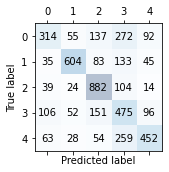

In [47]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('confusion_matrix.png', dpi=300)
plt.show()